# Finding steady states of genetic circuit from rates

There are 4 types of rates: creation / degration, and coupling / decoupling (aka association / dissociation). From these, steady states should be able to be worked out.

In [23]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import diffrax as dfx

## Base rates

The steady state average amount of RNA in E. coli is about 0.18 (median of 0.05 mRNAs per gene) and an mRNA life span of ca. 5-10 minutes ([from "Quantifying E. coli proteome and transcriptome with single-molecule sensitivity in single cells" (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2922915/)) with around 4764 genes ([from "A functional update of the Escherichia coli K-12 genome" (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC56896/)). Other sources report 0.4 mRNAs per gene per cell (with a range of ca. 0.02 - 3 mRNAs/gene/cell) estimated as 1380 total mRNAs ([from "Sizing up metatranscriptomics" (2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401/)), but these seem to be less accurate, as they cite the first source in an ambiguous way. Using the median mRNA count, a median total mRNA count per cell of ca. $4764 * 0.05 = 238.2 \approx 200$ mRNA, while the mean gives around $4764 * 0.18 = 857.52 \approx 850$ mRNA.

RNA transcription occurs at a rate of approximately 39-55 nucleotides per second in E. coli ([from bionumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=104900)). Since the RNA being considered for simplified genetic circuits are very short in length (in order to remain within a manageable combinatorial sequence space), we assume a nucleotide length of 20 per RNA molecule. This would make the removal rate the following:

$$ \frac{dRNA}{dt} = k_{prod} - k_{rem}*RNA $$
$$ \overline{RNA} = \frac{k_{prod}}{k_{rem}} = 850 molecules $$
$$ k_{prod1} = \frac{39 nt/s}{20 nt/molecule} = 1.95 molecules/s $$
$$ k_{prod2} = \frac{55 nt/s}{20 nt/molecule} = 2.75 molecules/s $$

Using mean mRNA count:
$$ k_{rem1} = \frac{k_{prod}}{\overline{RNA}} = \frac{1.95 molecules/s}{850 molecules} = 0.00229 s^{-1} $$
$$ k_{rem2} = \frac{k_{prod}}{\overline{RNA}} = \frac{2.75 molecules/s}{850 molecules} = 0.00324 s^{-1} $$

$$ t_{1/2} = ln(2)/k_{rem1} = ln(2) / 0.00229 min^{-1} = 302.684 s \approx 5 min $$
$$ t_{1/2} = ln(2)/k_{rem2} = ln(2) / 0.00324 min^{-1} = 213.934 s \approx 3.5 min $$

Using median mRNA count:
$$ k_{rem1} = \frac{k_{prod}}{\overline{RNA}} = \frac{1.95 molecules/s}{200 molecules} = 0.00975 s^{-1} $$
$$ k_{rem2} = \frac{k_{prod}}{\overline{RNA}} = \frac{2.75 molecules/s}{200 molecules} = 0.01375 s^{-1} $$

$$ t_{1/2} = ln(2)/k_{rem1} = ln(2) / 0.00975 s^{-1} = 71.092 s \approx 1.2 min $$
$$ t_{1/2} = ln(2)/k_{rem2} = ln(2) / 0.01375 s^{-1} = 50.411 s \approx 0.8 min $$

The half life of the calculated removal rate of ca. 3-5 minutes (using the mean mRNA number) falls within the expected range of 5-10 minutes. 
Here are some simulations to show the expected settling time.

Using mean mRNA count: the settling time is approximately  117.0 s, or  1.95 mins
Using median mRNA count: the settling time is approximately  667.0 s, or  11.116667 mins


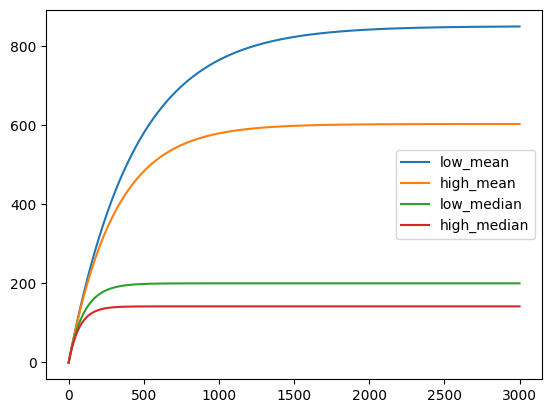

In [55]:

rna_steady_m = 850
rna_steady_med = 200
k_prod1 = 1.95
k_prod2 = 2.75
k_rem1m = k_prod1 / rna_steady_m
k_rem2m = k_prod2 / rna_steady_m
k_rem1 = k_prod1 / rna_steady_med
k_rem2 = k_prod2 / rna_steady_med


def dRNA(t, RNA, args, k_rem):
    return k_prod1 - k_rem * RNA


f_rna1m = dfx.ODETerm(partial(dRNA, k_rem = k_rem1m))
f_rna2m = dfx.ODETerm(partial(dRNA, k_rem = k_rem2m))
f_rna1 = dfx.ODETerm(partial(dRNA, k_rem = k_rem1))
f_rna2 = dfx.ODETerm(partial(dRNA, k_rem = k_rem2))
t0, t1, dt0 = 0, 3000, 1
y0 = 0
rna1m = dfx.diffeqsolve(f_rna1m, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                      y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
rna2m = dfx.diffeqsolve(f_rna2m, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                      y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
rna1 = dfx.diffeqsolve(f_rna1, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                      y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
rna2 = dfx.diffeqsolve(f_rna2, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                      y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)

plt.plot(rna1m.ts, rna1m.ys)
plt.plot(rna2m.ts, rna2m.ys)
plt.plot(rna1.ts, rna1.ys)
plt.plot(rna2.ts, rna2.ys)
plt.legend(['low_mean', 'high_mean', 'low_median', 'high_median'])

print('Using mean mRNA count: the settling time is approximately ', rna1m.ts[np.argmax((rna1m.ys >= rna_steady_med - 0.3) & (
    rna1m.ys <= rna_steady_med + 0.3))], 's, or ', rna1m.ts[np.argmax((rna1m.ys >= rna_steady_med - 0.3) & (rna1m.ys <= rna_steady_med + 0.3))] / 60, 'mins')
print('Using median mRNA count: the settling time is approximately ', rna1.ts[np.argmax((rna1.ys >= rna_steady_med - 0.3) & (
    rna1.ys <= rna_steady_med + 0.3))], 's, or ', rna1.ts[np.argmax((rna1.ys >= rna_steady_med - 0.3) & (rna1.ys <= rna_steady_med + 0.3))] / 60, 'mins')


## Lifespan of mRNA

Since the removal rate of mRNA has been calculated through the steady state mRNA count and the mRNA transcription rates, it varies considerably depending on which steady state and rate combination is used. Choosing the most appropriate estimates can therefore be ascertained by matching the calculated removal rate to the expected lifespan of the mRNA.

Using low mean mRNA count: the mRNA lifespan is approximately  2309.6023 s, or  38.49337 mins
Using high mean mRNA count: the mRNA lifespan is approximately  1637.7472 s, or  27.295786 mins
Using low median mRNA count: the mRNA lifespan is approximately  543.51434 s, or  9.058573 mins
Using high median mRNA count: the mRNA lifespan is approximately  385.4143 s, or  6.4235716 mins


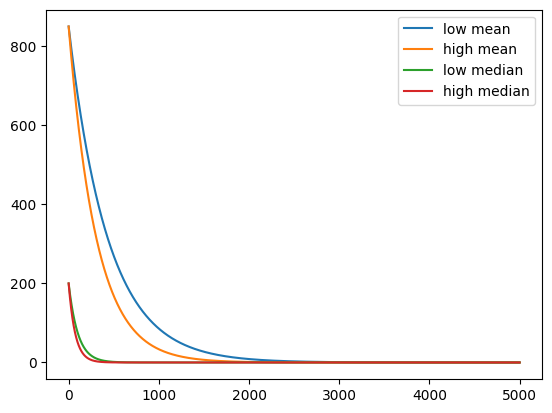

In [65]:
def degx(t, y, args, k_rem):
    # return k_prod1/k_rem1 - rna_steady * np.exp(-k_rem1 * t)
    return -k_rem * y


f_degx1m = dfx.ODETerm(partial(degx, k_rem=k_rem1m))
f_degx2m = dfx.ODETerm(partial(degx, k_rem=k_rem2m))
f_degx1 = dfx.ODETerm(partial(degx, k_rem=k_rem1))
f_degx2 = dfx.ODETerm(partial(degx, k_rem=k_rem2))
t0, t1, dt0 = 0, 5000, 0.1
y0m = rna_steady_m
# y0m = 1
deg1m = dfx.diffeqsolve(f_degx1m, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                        y0=y0m, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
deg2m = dfx.diffeqsolve(f_degx2m, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                        y0=y0m, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
y0= rna_steady_med
# y0 = 1
deg1 = dfx.diffeqsolve(f_degx1, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                       y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
deg2 = dfx.diffeqsolve(f_degx2, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                       y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)

plt.plot(deg1m.ts, deg1m.ys)
plt.plot(deg2m.ts, deg2m.ys)
plt.plot(deg1.ts, deg1.ys)
plt.plot(deg2.ts, deg2.ys)
plt.legend(['low mean', 'high mean', 'low median', 'high median'])

print('Using low mean mRNA count: the mRNA lifespan is approximately ', deg1m.ts[np.argmax(
    (deg1m.ys <= 0.005 * y0m))], 's, or ', deg1m.ts[np.argmax((deg1m.ys <= 0.005 * y0m))] / 60, 'mins')
print('Using high mean mRNA count: the mRNA lifespan is approximately ', deg2m.ts[np.argmax(
    (deg2m.ys <= 0.005 * y0m))], 's, or ', deg2m.ts[np.argmax((deg2m.ys <= 0.005 * y0m))] / 60, 'mins')
print('Using low median mRNA count: the mRNA lifespan is approximately ', deg1.ts[np.argmax(
    (deg1.ys <= 0.005 * y0))], 's, or ', deg1.ts[np.argmax((deg1.ys <= 0.005 * y0))] / 60, 'mins')
print('Using high median mRNA count: the mRNA lifespan is approximately ', deg2.ts[np.argmax(
    (deg2.ys <= 0.005 * y0))], 's, or ', deg2.ts[np.argmax((deg2.ys <= 0.005 * y0))] / 60, 'mins')


From the simulations, the average mRNA production rates available do not have as big of an impact on the lifespan as the steady state mRNA. The mRNA lifespan resulting from the median steady state mRNA count correspond fairly well with the expected lifespan of 5-10 minutes. The steady state mRNA from the mean mRNA counts however has a much longer lifespan than expected. We will therefore use the median mRNA count as the steady state for total mRNA in an E. coli cell. The production rate used will be the average of the low and high estimates, so $2.35 s^{-1}$.

Summary:

$$RNA_{steady} = 200 molecules / cell$$
$$RNA_{production} = 2.35 s^{-1}$$
